
# ANTs × Cellpose Registration QC — Centroid Distances in µm

**Created:** 2025-10-15 12:22

This notebook computes distances (in µm) between **cort-positive cell centroids** segmented by Cellpose in two modalities:
- **Confocal** (panneuronal GC + cort HCR in red) — *moving image* (registered to 2P)
- **2P** (panneuronal GC + cort::mCherry) — *fixed image*

The pipeline:
1. Load Cellpose `*_seg.npy` outputs and extract labeled masks.
2. Compute object centroids.
3. Convert pixel indices to physical units using voxel spacings (µm).
4. Apply the **confocal → 2P** ANTs transform to confocal centroids.
5. Match cells (nearest neighbor or Hungarian) and compute distances in µm.
6. Summaries and basic plots; optional gating to reject outliers.



## Requirements

- `numpy`, `pandas`, `scikit-image`, `scipy`, `matplotlib`
- `ants` (ANTsPy) **optional but recommended** for applying transforms inside Python.
  - If `ants` is not available, the notebook will export centroids to CSV and you can run
    `antsApplyTransformsToPoints` on the command line, then re-import the transformed CSV.

> Tip: For 3D Cellpose, pass correct anisotropy during segmentation to reduce z-bias.


## 0) User inputs

In [1]:

# --- Paths to Cellpose outputs ---
CONF_SEG_NPY = "/Users/ddharmap/dataProcessing/2p_HCR/data/L427_f02/L427_f02_round1_channel2_cort_gauss_seg_20251006.npy"   # path to confocal *_seg.npy
TWOP_SEG_NPY = "/Users/ddharmap/dataProcessing/2p_HCR/data/L427_f02/L427_f02_anatomy_2P_cort_seg_anis1.npy"       # path to 2P *_seg.npy

# FILL THESE to the exact images used during registration:
CONF_NRRD_PATH = "/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L427_f02/02_reg/00_preprocessing/r1/L427_f02_round1_channel2_cort.nrrd"
TWOP_NRRD_PATH = "/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L427_f02/02_reg/00_preprocessing/2p_anatomy/L427_f02_anatomy_2P_cort.nrrd"

# --- ANTs transform files (moving=confocal -> fixed=2P) ---
# include the non-linear warp BEFORE the affine in the list
ANTs_TRANSFORMS = [
    "/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L427_f02/02_reg/01_r1-2p/transMatrices/L427_f02_round1_GCaMP_to_ref1Warp.nii.gz",          # example SyN warp, forward transformation
    # "/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L427_f02/02_reg/01_r1-2p/transMatrices/L427_f02_round1_GCaMP_to_ref1InverseWarp.nii.gz"    , # example SyN warp, inverse transformation
    "/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L427_f02/02_reg/01_r1-2p/transMatrices/L427_f02_round1_GCaMP_to_ref0GenericAffine.mat"     # example affine
]

# --- Voxel spacings in microns ---
# Fill these from your image metadata
# 3D stacks: dz, dy, dx; 2D stacks: dy, dx
VOX_CONF = {"dz": 1.0, "dy": 0.2075665, "dx": 0.2075665}  # example for confocal
VOX_2P   = {"dz": 2.0, "dy": 0.6506220, "dx": 0.6506220}  # example for 2P

# --- Matching parameters ---
MATCH_METHOD = "nn"    # "nn" for nearest neighbor, "hungarian" for 1–1 global assignment
MAX_DISTANCE_UM = 5.0 # gate for valid matches (~1 soma diameter is a good start)
RANDOM_SEED = 42

INVERT_AFFINE = True  # discovered by your test Variant B

# Optional global toggle (set once in your params cell)
try:
    INVERT_AFFINE
except NameError:
    INVERT_AFFINE = True  # <-- discovered by your test Variant B

## 1) Imports and helper functions

In [2]:

import os, sys, json, time
import numpy as np
import pandas as pd

from skimage.measure import regionprops_table
from scipy.spatial import cKDTree
from scipy.optimize import linear_sum_assignment

import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Dropdown
from IPython.display import display, HTML

# Try to import ANTsPy
try:
    import ants
    HAVE_ANTSPY = True
except Exception as e:
    HAVE_ANTSPY = False
    print("ANTsPy not found; will enable CSV export/import route for transforms.\n", e)

rng = np.random.default_rng(RANDOM_SEED)

def fs_info(path: str) -> dict:
    """Lightweight filesystem info."""
    exists = os.path.exists(path)
    size_b = os.path.getsize(path) if exists else None
    mtime  = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(os.path.getmtime(path))) if exists else None
    return {"exists": exists, "size_bytes": size_b, "size_MB": (size_b/1e6 if size_b else None), "modified": mtime}

def physical_extent_um(mask: np.ndarray, vox: dict) -> tuple:
    """Return (Z_um, Y_um, X_um) or (Y_um, X_um) physical field-of-view from mask shape and voxel sizes."""
    if mask.ndim == 3:
        Z, Y, X = mask.shape
        return (Z * vox["dz"], Y * vox["dy"], X * vox["dx"])
    else:
        Y, X = mask.shape
        return (Y * vox["dy"], X * vox["dx"])

def summarize_dataset(name: str, path: str, masks: np.ndarray, vox: dict) -> dict:
    """One-row summary for a dataset (used in the table view)."""
    base = os.path.basename(path)
    fs = fs_info(path)
    uniq = np.unique(masks)
    n_cells = int(uniq.size - (1 if uniq.size and uniq[0] == 0 else 0))
    fov = physical_extent_um(masks, vox)
    row = {
        "dataset": name,
        "file": base,
        "path": path,
        "exists": fs["exists"],
        "size_MB": round(fs["size_MB"], 3) if fs["size_MB"] else None,
        "modified": fs["modified"],
        "shape": tuple(masks.shape),
        "ndim": masks.ndim,
        "dtype": str(masks.dtype),
        "min_label": int(masks.min()),
        "max_label": int(masks.max()),
        "n_cells": n_cells,
        "voxel_um": (vox["dz"], vox["dy"], vox["dx"]) if masks.ndim == 3 else (vox["dy"], vox["dx"]),
        "FOV_um": tuple(round(v, 3) for v in fov),
        "n_voxels": int(masks.size),
        "anisotropy_z_over_y": (vox["dz"]/vox["dy"]) if masks.ndim == 3 else None,
    }
    return row

def load_cellpose_masks(seg_path: str) -> np.ndarray:
    """Robustly load Cellpose *_seg.npy (dict) or a raw label array (.npy/.npz).
    Returns a labeled mask ndarray (2D or 3D).
    """
    if not os.path.exists(seg_path):
        raise FileNotFoundError(f"File not found: {seg_path}")

    try:
        obj = np.load(seg_path, allow_pickle=True)
    except Exception as e:
        raise OSError(f"Failed to load {seg_path}. If this is on a network/cloud drive, "
                      f"copy it locally and retry. Original error: {e}")

    # .npz container?
    if isinstance(obj, np.lib.npyio.NpzFile):
        if 'masks' in obj.files:
            return obj['masks']
        raise KeyError(f"{seg_path} is .npz but has no 'masks'. Keys: {obj.files}")

    # Cellpose *_seg.npy is a pickled dict inside an .npy
    if hasattr(obj, "item"):
        try:
            dat = obj.item()
        except Exception as e:
            raise OSError(f"{seg_path} appears corrupted (cannot unpickle dict). {e}")
        masks = dat.get('masks', None)
        if masks is None:
            raise KeyError(f"'masks' not found in {seg_path}. Keys: {list(dat.keys())}")
        return masks

    # raw array case
    if isinstance(obj, np.ndarray):
        return obj

    raise TypeError(f"Unexpected content in {seg_path}: {type(obj)}")

def mask_summary(mask: np.ndarray, name: str = "") -> dict:
    """Return a small dict summarizing a labeled mask."""
    # unique() can be heavy for huge volumes; use it here for truth, but you can swap to mask.max() if needed
    uniq = np.unique(mask)
    n_cells = int(uniq.size - (1 if uniq.size and uniq[0] == 0 else 0))
    return {
        "name": name,
        "shape": tuple(mask.shape),
        "ndim": mask.ndim,
        "dtype": str(mask.dtype),
        "min": int(mask.min()),
        "max": int(mask.max()),
        "n_cells": n_cells,
    }

def safe_slice(arr: np.ndarray, z: int) -> np.ndarray:
    """Return arr[z] for 3D, or arr for 2D, with z safely clamped."""
    if arr.ndim == 2:
        return arr
    z = int(np.clip(z, 0, arr.shape[0] - 1))
    return arr[z]

def _ants_from_mask(mask: np.ndarray, vox: dict, ants):
    """
    Build an ANTsImage from a numpy label mask.
    The NumPy array is (Z,Y,X) for 3D or (Y,X) for 2D.
    ANTs expects spacing in (x,y[,z]) order.
    """
    if mask.ndim == 3:
        img = ants.from_numpy(mask.astype(np.int32))
        img.set_spacing((vox["dx"], vox["dy"], vox["dz"]))
        # origin/direction left at defaults; OK for resampling into a provided reference
    else:
        img = ants.from_numpy(mask.astype(np.int32))
        img.set_spacing((vox["dx"], vox["dy"]))
    return img

# # Old function; replaced by script underneath
# def warp_label_mask_with_ants(
#     moving_mask: np.ndarray,
#     moving_vox: dict,
#     fixed_vox: dict,
#     transform_list: list,
#     ants,
#     fixed_mask_for_ref: np.ndarray | None = None,
#     fixed_shape: tuple | None = None,
# ):
#     """
#     Warp a *label* mask (confocal) into the fixed (2P) space using ANTs transforms.
#     - Uses nearest-neighbor interpolation to preserve label integers.
#     - Reference grid is taken from fixed_mask_for_ref (preferred) or fixed_shape+fixed_vox.

#     Returns: numpy array label mask in fixed space (same shape as reference).
#     """
#     # Build moving image (confocal labels)
#     mov_img = _ants_from_mask(moving_mask, moving_vox, ants)

#     # Build reference image (2P grid)
#     if fixed_mask_for_ref is not None:
#         ref_img = _ants_from_mask(fixed_mask_for_ref, fixed_vox, ants)
#     else:
#         # create an empty ANTs image with desired shape & spacing
#         if fixed_shape is None:
#             raise ValueError("Provide fixed_mask_for_ref or fixed_shape+fixed_vox to define reference space.")
#         if len(fixed_shape) == 3:
#             ref_img = ants.from_numpy(np.zeros(fixed_shape, dtype=np.int16))
#             ref_img.set_spacing((fixed_vox["dx"], fixed_vox["dy"], fixed_vox["dz"]))
#         else:
#             ref_img = ants.from_numpy(np.zeros(fixed_shape, dtype=np.int16))
#             ref_img.set_spacing((fixed_vox["dx"], fixed_vox["dy"]))

#     # Apply transforms (moving -> fixed)
#     warped = ants.apply_transforms(
#         fixed=ref_img,
#         moving=mov_img,
#         transformlist=transform_list,
#         interpolator="nearestNeighbor",
#     )
#     return warped.numpy().astype(moving_mask.dtype)

def warp_label_mask_with_ants(
    moving_mask: np.ndarray,
    moving_vox: dict,
    fixed_vox: dict,
    transform_list: list,
    ants,
    fixed_mask_for_ref: np.ndarray | None = None,
    fixed_shape: tuple | None = None,
):
    """
    Warp a *label* mask (confocal) into the fixed (2P) space using ANTs transforms.
    - Keeps existing function signature for downstream compatibility.
    - Internally converts (Z,Y,X) -> (X,Y,Z) for ANTs, applies transforms, then returns (Z,Y,X).
    - Uses nearest-neighbor interpolation to preserve label integers.
    - Inverts the affine (.mat) by default (see INVERT_AFFINE), keeps warp forward.
    - Reference grid is taken from fixed_mask_for_ref (preferred) or fixed_shape+fixed_vox.
    """
    import numpy as np
    # 1) Build moving image (labels) in XYZ for ANTs
    if moving_mask.ndim == 3:
        mask_xyz = np.transpose(moving_mask, (2, 1, 0))  # (Z,Y,X) -> (X,Y,Z)
        mov_img = ants.from_numpy(mask_xyz.astype(np.int32, copy=False))
        # spacing must be (dx,dy,dz)
        mov_img.set_spacing((moving_vox["dx"], moving_vox["dy"], moving_vox["dz"]))
    elif moving_mask.ndim == 2:
        mov_img = ants.from_numpy(moving_mask.astype(np.int32, copy=False))
        mov_img.set_spacing((moving_vox["dx"], moving_vox["dy"]))
    else:
        raise ValueError("moving_mask must be 2D or 3D")

    # 2) Build reference image (fixed grid) in XYZ
    if fixed_mask_for_ref is not None:
        if fixed_mask_for_ref.ndim == 3:
            ref_xyz = np.transpose(fixed_mask_for_ref, (2, 1, 0))
            ref_img = ants.from_numpy(ref_xyz.astype(np.int16, copy=False))
            ref_img.set_spacing((fixed_vox["dx"], fixed_vox["dy"], fixed_vox["dz"]))
        else:
            ref_img = ants.from_numpy(fixed_mask_for_ref.astype(np.int16, copy=False))
            ref_img.set_spacing((fixed_vox["dx"], fixed_vox["dy"]))
    else:
        if fixed_shape is None:
            raise ValueError("Provide fixed_mask_for_ref or fixed_shape+fixed_vox to define reference space.")
        # fixed_shape is expected in (Z,Y,X) for 3D or (Y,X) for 2D in your code;
        # create an ANTs image of zeros in XYZ for 3D.
        if len(fixed_shape) == 3:
            fx = (fixed_shape[2], fixed_shape[1], fixed_shape[0])
            ref_img = ants.from_numpy(np.zeros(fx, dtype=np.int16))
            ref_img.set_spacing((fixed_vox["dx"], fixed_vox["dy"], fixed_vox["dz"]))
        else:
            ref_img = ants.from_numpy(np.zeros(fixed_shape, dtype=np.int16))
            ref_img.set_spacing((fixed_vox["dx"], fixed_vox["dy"]))

    # 3) Build whichtoinvert: keep warp forward, invert affine if requested
    whichtoinvert = []
    for t in transform_list:
        t_str = str(t)
        if t_str.endswith("InverseWarp.nii.gz"):
            # already an inverse warp file → do not invert
            whichtoinvert.append(False)
        elif t_str.endswith("Warp.nii.gz"):
            # forward nonlinear warp → do not invert
            whichtoinvert.append(False)
        elif t_str.endswith(".mat"):
            # affine: invert according to global flag
            whichtoinvert.append(bool(INVERT_AFFINE))
        else:
            # default: do not invert
            whichtoinvert.append(False)

    # 4) Apply transforms (moving -> fixed) with NN (labels)
    warped_xyz = ants.apply_transforms(
        fixed=ref_img,
        moving=mov_img,
        transformlist=transform_list,
        whichtoinvert=whichtoinvert,
        interpolator="nearestNeighbor",
    ).numpy()

    # 5) Return in original layout (Z,Y,X) and dtype preserved
    if moving_mask.ndim == 3:
        warped_zyx = np.transpose(warped_xyz, (2, 1, 0)).astype(moving_mask.dtype, copy=False)
        return warped_zyx
    else:
        return warped_xyz.astype(moving_mask.dtype, copy=False)

def compute_centroids(mask):
    """Return DataFrame of labels and centroids from a labeled mask (2D or 3D)."""
    props = regionprops_table(mask, properties=("label", "centroid"))
    df = pd.DataFrame(props)
    # Ensure consistent column names: z,y,x for 3D; y,x for 2D
    if mask.ndim == 3:
        df = df.rename(columns={"centroid-0":"z", "centroid-1":"y", "centroid-2":"x"})
    else:
        df = df.rename(columns={"centroid-0":"y", "centroid-1":"x"})
    return df

def idx_to_um(df_centroids, vox):
    """Convert centroid indices to microns using spacing dict vox."""
    if "z" in df_centroids.columns:
        arr = df_centroids[["z","y","x"]].to_numpy(dtype=float)
        arr[:,0] *= vox["dz"]
        arr[:,1] *= vox["dy"]
        arr[:,2] *= vox["dx"]
        return arr
    else:
        arr = df_centroids[["y","x"]].to_numpy(dtype=float)
        arr[:,0] *= vox["dy"]
        arr[:,1] *= vox["dx"]
        return arr

def um_to_idx_df(points_um, vox, is3d):
    """Convert points in µm to MOVING image index units with columns x,y,(z)."""
    if is3d:
        return pd.DataFrame({
            "x": points_um[:,2] / vox["dx"],
            "y": points_um[:,1] / vox["dy"],
            "z": points_um[:,0] / vox["dz"],
        })[["x","y","z"]]
    else:
        return pd.DataFrame({
            "x": points_um[:,1] / vox["dx"],
            "y": points_um[:,0] / vox["dy"],
        })[["x","y"]]

def idx_df_to_um(df_idx, vox, is3d):
    """Convert FIXED image index-units DataFrame (x,y,(z)) to µm ndarray (ordered as y/x -> µm & z first for 3D)."""
    if is3d:
        x = df_idx["x"].to_numpy(); y = df_idx["y"].to_numpy(); z = df_idx["z"].to_numpy()
        return np.c_[ z * vox["dz"],  y * vox["dy"],  x * vox["dx"] ]  # returns [µm_z, µm_y, µm_x]
    else:
        x = df_idx["x"].to_numpy(); y = df_idx["y"].to_numpy()
        return np.c_[ y * vox["dy"],  x * vox["dx"] ]  # returns [µm_y, µm_x]

def apply_ants_transform_to_points(conf_pts_um, is3d, ants_transforms, vox_conf, vox_2p):
    """Apply confocal->2P transforms to confocal points in µm. Return points in 2P µm."""
    if not HAVE_ANTSPY:
        raise RuntimeError("ANTsPy not available.")
    moving_idx = um_to_idx_df(conf_pts_um, vox_conf, is3d)
    # antspyx signature: apply_transforms_to_points(dim, points, transformlist, whichtoinvert=None)
    fixed_idx = ants.apply_transforms_to_points(3 if is3d else 2, moving_idx, ants_transforms)
    fixed_um = idx_df_to_um(fixed_idx, vox_2p, is3d)
    return fixed_um

def nearest_neighbor_match(A_um, B_um):
    """For each row in A, find nearest neighbor in B. Returns distances and indices."""
    tree = cKDTree(B_um)
    dists, nn = tree.query(A_um, k=1)
    return dists, nn

def hungarian_match(A_um, B_um, max_cost=np.inf):
    """1–1 assignment using Hungarian algorithm with optional max_cost gate."""
    # Compute cost matrix
    # Beware of large N: O(N^2) memory
    from scipy.spatial.distance import cdist
    C = cdist(A_um, B_um)
    if np.isfinite(max_cost):
        C = np.where(C > max_cost, max_cost * 10.0, C)  # penalize invalid matches
    row_ind, col_ind = linear_sum_assignment(C)
    dists = C[row_ind, col_ind]
    return dists, col_ind, row_ind

def summarize_distances(dists, valid_mask):
    if valid_mask.any():
        return {
            "N_total": int(dists.size),
            "N_within_gate": int(valid_mask.sum()),
            "frac_within_gate": float(valid_mask.mean()),
            "median_um": float(np.median(dists[valid_mask])),
            "p90_um": float(np.percentile(dists[valid_mask], 90)),
        }
    else:
        return {
            "N_total": int(dists.size),
            "N_within_gate": 0,
            "frac_within_gate": 0.0,
            "median_um": np.nan,
            "p90_um": np.nan,
        }
    
def array_sample_table(mask: np.ndarray, n: int = 20, name: str = "") -> pd.DataFrame:
    """Return a small DataFrame showing n random voxel entries (z,y,x,value) for intuition.
    Works for 2D or 3D arrays.
    """
    rng = np.random.default_rng(42)
    coords = np.array(np.unravel_index(rng.choice(mask.size, size=min(n, mask.size), replace=False),
                                       mask.shape)).T
    vals = mask.ravel()[np.ravel_multi_index(coords.T, mask.shape)]
    if mask.ndim == 3:
        df = pd.DataFrame(coords, columns=["z","y","x"])
    else:
        df = pd.DataFrame(coords, columns=["y","x"])
    df["value"] = vals
    df.insert(0, "dataset", name)
    return df

def _summary(mask: np.ndarray, name: str):
    uniq = np.unique(mask)
    n_labels = int(uniq.size - (1 if uniq.size and uniq[0] == 0 else 0))
    print(f"[{name}] shape={mask.shape} ndim={mask.ndim} dtype={mask.dtype} "
          f"min={mask.min()} max={mask.max()} labels(excl 0)={n_labels}")

def _sample_table(mask: np.ndarray, n=20, name=""):
    rng = np.random.default_rng(0 if name=="BEFORE" else 1)  # different seeds
    idx = rng.choice(mask.size, size=min(n, mask.size), replace=False)
    coords = np.array(np.unravel_index(idx, mask.shape)).T
    vals = mask.ravel()[idx]
    if mask.ndim == 3:
        df = pd.DataFrame(coords, columns=["z","y","x"])
    else:
        df = pd.DataFrame(coords, columns=["y","x"])
    df["value"] = vals
    df.insert(0, "dataset", name)
    # sort for readability
    sort_cols = ["z","y","x"] if mask.ndim == 3 else ["y","x"]
    df = df.sort_values(sort_cols).reset_index(drop=True)
    return df

# ---------- Geometry helpers ----------
def clone_geometry_from(img_src, img_dst):
    """Copy spacing, origin, direction from img_src (ANTsImage) to img_dst (ANTsImage); returns img_dst."""
    img_dst.set_spacing(img_src.spacing)
    img_dst.set_origin(img_src.origin)
    img_dst.set_direction(img_src.direction)
    return img_dst

def ants_from_mask_with_geometry(mask_np, like_img, ants, dtype=np.int32):
    """Create ANTsImage from numpy mask and clone geometry from an existing ANTsImage."""
    img = ants.from_numpy(mask_np.astype(dtype))
    return clone_geometry_from(like_img, img)

def index_bounds(ants_img):
    """Return (min_xyz, max_xyz) physical bounds of an ANTs image (exclusive max)."""
    sz = ants_img.shape  # (x,y,z) in ANTs
    sp = ants_img.spacing
    org = ants_img.origin
    # direction is a 3x3
    import numpy as _np
    D = _np.array(ants_img.direction).reshape(3,3)
    max_idx = _np.array(sz) - 1
    # corners: 0..max -> physical via origin + D*(idx*spacing)
    corners = []
    for ix in [0, max_idx[0]]:
        for iy in [0, max_idx[1]]:
            for iz in [0, max_idx[2]] if len(sz) == 3 else [0]:
                p = org + D.dot(_np.array([ix*sp[0], iy*sp[1], iz*sp[2] if len(sz)==3 else 0.0]))
                corners.append(p)
    corners = _np.vstack(corners)
    return corners.min(axis=0), corners.max(axis=0)

def points_inside_fixed(points_xyz, fixed_img):
    """Return boolean mask whether each (x,y,z) point lies within fixed image physical bounds (inclusive)."""
    import numpy as _np
    lo, hi = index_bounds(fixed_img)
    P = _np.asarray(points_xyz)
    return (P >= lo).all(axis=1) & (P <= hi).all(axis=1)



## 3) Inspect datasets

Masks are represented by a .npy array (z, y, x, label) that represent the voxel location in space and to which cells they belong (0 = background). There should be non-zero labels if any cells are found by cellpose.

,dataset,file,exists,size_MB,modified,shape,ndim,dtype,min_label,max_label,n_cells,nonzero_voxels,frac_nonzero_pct,voxel_um,FOV_um,n_voxels,anisotropy_z_over_y,path
0,Confocal (HCR),L427_f02_round1_channel2_cort_gauss_seg_202510...,True,16252.932,2025-10-15 07:15:07,"(155, 2048, 2048)",3,uint16,0,191,191,850366,0.1308,"(1.0, 0.2075665, 0.2075665)","(155.0, 425.096, 425.096)",650117120,4.817733,/Users/ddharmap/dataProcessing/2p_HCR/data/L42...
1,2P (mCherry),L427_f02_anatomy_2P_cort_seg_anis1.npy,True,2756.266,2025-10-06 09:32:37,"(196, 750, 750)",3,uint16,0,939,939,322698,0.2927,"(2.0, 0.650622, 0.650622)","(392.0, 487.967, 487.967)",110250000,3.073982,/Users/ddharmap/dataProcessing/2p_HCR/data/L42...


Saved table to input_datasets_overview.csv

Random voxel samples (label structure):


dataset,z,y,x,value
Confocal,14,1223,1345,0
Confocal,119,1972,1231,0
Confocal,130,329,1386,0
Confocal,69,1658,1048,0
Confocal,114,85,470,0
Confocal,31,466,1000,0
Confocal,111,427,2017,0
Confocal,79,1126,1315,0
Confocal,13,1707,1683,0
Confocal,101,939,363,0


Saved array_structure_samples.csv

Per-Z nonzero counts & preview (Confocal):


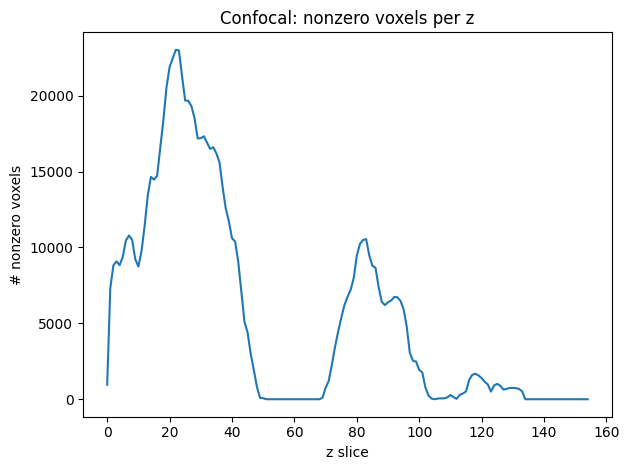

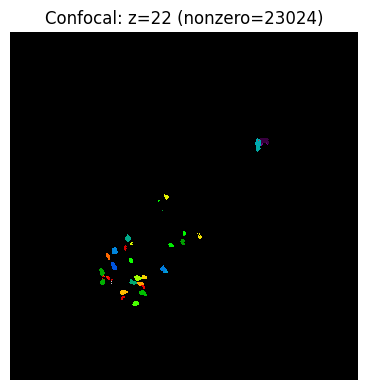

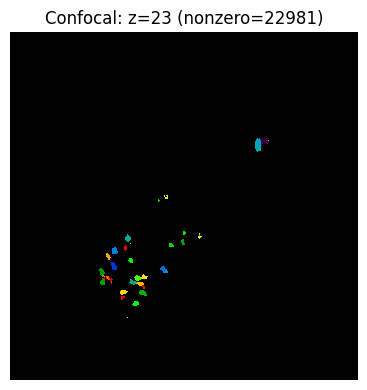

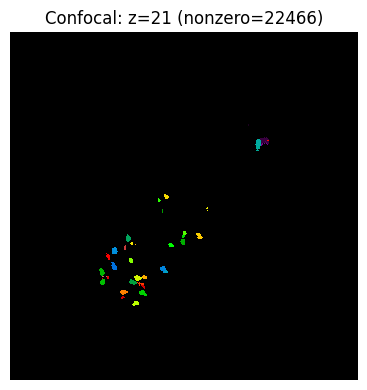


Per-Z nonzero counts & preview (2P):


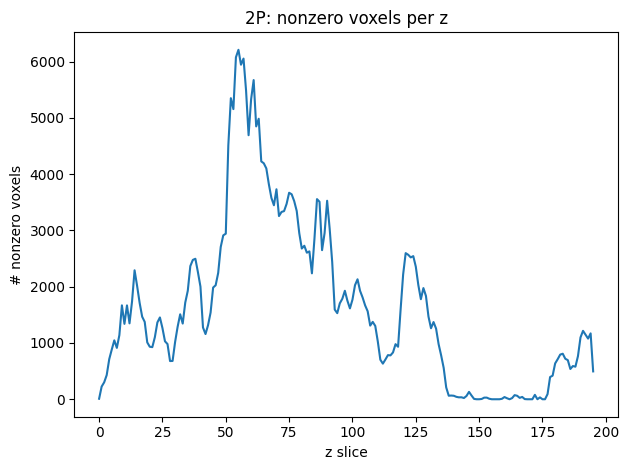

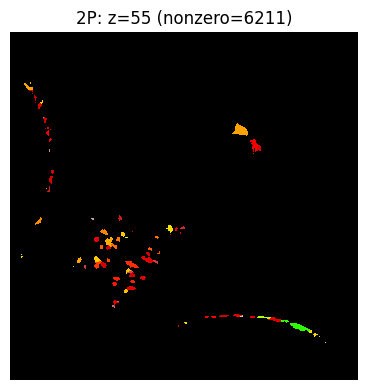

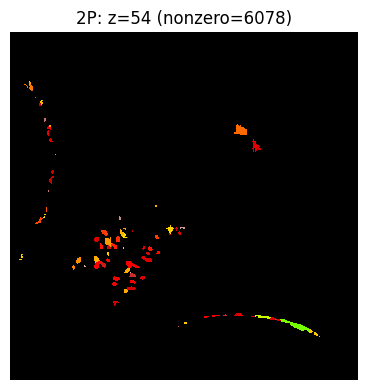

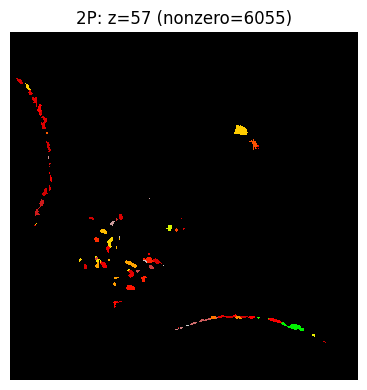

In [3]:
# ==== Expanded oversight: verify non-zero labels in inputs (confocal & 2P) ====
# Load (robust helper already handles dict/raw npy)
masks_conf = load_cellpose_masks(CONF_SEG_NPY)
masks_2p   = load_cellpose_masks(TWOP_SEG_NPY)

# Build the basic table (your original)
rows = [
    summarize_dataset("Confocal (HCR)", CONF_SEG_NPY, masks_conf, VOX_CONF),
    summarize_dataset("2P (mCherry)",   TWOP_SEG_NPY, masks_2p,   VOX_2P),
]
df_inputs = pd.DataFrame(rows)

# ---- NEW: add explicit non-zero voxel stats ----
def _nz_stats(mask: np.ndarray):
    nz = int((mask > 0).sum())
    frac = nz / mask.size
    if mask.ndim == 3:
        nz_per_z = (mask > 0).reshape(mask.shape[0], -1).sum(axis=1)
    else:
        nz_per_z = None
    return nz, frac, nz_per_z

nz_conf, frac_conf, nz_per_z_conf = _nz_stats(masks_conf)
nz_2p,   frac_2p,   nz_per_z_2p   = _nz_stats(masks_2p)

df_inputs["nonzero_voxels"]     = [nz_conf, nz_2p]
df_inputs["frac_nonzero_pct"]   = [round(frac_conf*100, 4), round(frac_2p*100, 4)]
df_inputs["has_any_labels"]     = [nz_conf > 0, nz_2p > 0]

# Choose readable column order
cols = [
    "dataset","file","exists","size_MB","modified",
    "shape","ndim","dtype","min_label","max_label","n_cells",
    "nonzero_voxels","frac_nonzero_pct",
    "voxel_um","FOV_um","n_voxels","anisotropy_z_over_y","path"
]
df_inputs = df_inputs[cols]

# Robust display (works without jinja2)
df_show = df_inputs.copy()
if "size_MB" in df_show.columns:
    df_show["size_MB"] = df_show["size_MB"].apply(lambda x: None if x is None else round(x, 3))
display(df_show)

df_inputs.to_csv("input_datasets_overview.csv", index=False)
print("Saved table to input_datasets_overview.csv")

# ---- NEW: random voxel samples (your original), kept for intuition ----
print("\nRandom voxel samples (label structure):")
df_conf_samp = array_sample_table(masks_conf, n=20, name="Confocal")
df_2p_samp   = array_sample_table(masks_2p,   n=20, name="2P")
df_samples = pd.concat([df_conf_samp, df_2p_samp], ignore_index=True)
display(HTML(df_samples.to_html(index=False).replace(
    "<table", '<table style="display:block; max-height:300px; overflow-y:auto; width:100%;"')))
df_samples.to_csv("array_structure_samples.csv", index=False)
print("Saved array_structure_samples.csv")

# ---- NEW: per-Z nonzero counts + quick preview of densest slices (3D only) ----
def _plot_nz_per_z(mask, title_prefix):
    if mask.ndim != 3:
        return
    nz_per_z = (mask > 0).reshape(mask.shape[0], -1).sum(axis=1)
    plt.figure()
    plt.plot(np.arange(mask.shape[0]), nz_per_z)
    plt.xlabel("z slice"); plt.ylabel("# nonzero voxels")
    plt.title(f"{title_prefix}: nonzero voxels per z")
    plt.tight_layout(); plt.show()
    # show up to 3 densest planes
    top = np.argsort(nz_per_z)[::-1][:3]
    for z in top:
        if nz_per_z[z] == 0:
            continue
        plt.figure(figsize=(4,4))
        plt.imshow(mask[z], cmap="nipy_spectral", interpolation="nearest")
        plt.title(f"{title_prefix}: z={z} (nonzero={int(nz_per_z[z])})")
        plt.axis("off"); plt.tight_layout(); plt.show()

print("\nPer-Z nonzero counts & preview (Confocal):")
_plot_nz_per_z(masks_conf, "Confocal")
print("\nPer-Z nonzero counts & preview (2P):")
_plot_nz_per_z(masks_2p, "2P")

## 3.0.1) Real image geometries

In [ ]:
# ==== Use original registered images for geometry ====
# FILL THESE to the exact images used during registration:
CONF_NRRD_PATH = "/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L427_f02/02_reg/00_preprocessing/r1/L427_f02_round1_channel2_cort.nrrd"
TWOP_NRRD_PATH = "/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L427_f02/02_reg/00_preprocessing/2p_anatomy/L427_f02_anatomy_2P_cort.nrrd"

mov_img_int = ants.image_read(CONF_NRRD_PATH)  # moving intensity (confocal) used in ANTs
fix_img_int = ants.image_read(TWOP_NRRD_PATH)  # fixed intensity (2P) used in ANTs

# Build label images with identical geometry to the intensity images
mov_label_img = ants_from_mask_with_geometry(masks_conf, mov_img_int, ants, dtype=np.int32)

# If you want a true 2P-grid label reference later, we can resample; for warping, use the fixed INTENSITY image:
fix_label_ref = fix_img_int  # best reference for apply_transforms
print("Moving (confocal) size/spacing:", mov_img_int.shape, mov_img_int.spacing)
print("Fixed (2P)     size/spacing:", fix_img_int.shape, fix_img_int.spacing)


Moving (confocal) size/spacing: (2048, 2048, 155) (0.20756645602494875, 0.20756645602494875, 1.0)
Fixed (2P)     size/spacing: (750, 750, 196) (0.6506220499674479, 0.6506220499674479, 2.0)


## 3.0.2) Trouble shooting

In [14]:
# ==== Correct point sanity check (ANTs returns PHYSICAL coords) ====

Z, Y, X = masks_conf.shape
pts_idx_zyx = np.array([
    [0,0,0], [0,0,X-1], [0,Y-1,0], [Z-1,0,0], [Z-1,Y-1,X-1], [Z//2, Y//2, X//2]
])

# convert NumPy index (z,y,x) → ANTs index order (x,y,z) before handing to ANTs
pts_idx_xyz = np.c_[pts_idx_zyx[:,2], pts_idx_zyx[:,1], pts_idx_zyx[:,0]]
df_pts = pd.DataFrame(pts_idx_xyz, columns=["x","y","z"])

# Map MOVING→FIXED; result is PHYSICAL coordinates in the FIXED frame
fixed_phys = ants.apply_transforms_to_points(3, df_pts, transformlist=ANTs_TRANSFORMS)

# Build fixed physical bounds from the actual fixed image used in registration
def physical_bounds(ants_img):
    import numpy as _np
    sz = _np.array(ants_img.shape)       # (x,y,z) voxels
    sp = _np.array(ants_img.spacing)     # (dx,dy,dz) µm (or whatever units the image used)
    org = _np.array(ants_img.origin)
    D   = _np.array(ants_img.direction).reshape(3,3)
    # generate the 8 corners in index then to physical
    idx_corners = _np.array([[0,0,0],[sz[0]-1,0,0],[0,sz[1]-1,0],[0,0,sz[2]-1],
                             [sz[0]-1,sz[1]-1,0],[sz[0]-1,0,sz[2]-1],[0,sz[1]-1,sz[2]-1],[sz[0]-1,sz[1]-1,sz[2]-1]])
    phys = org + (D @ (idx_corners * sp).T).T
    lo = phys.min(axis=0); hi = phys.max(axis=0)
    return lo, hi

lo, hi = physical_bounds(fix_img_int)
P = fixed_phys[["x","y","z"]].to_numpy()
inside = (P >= lo).all(axis=1) & (P <= hi).all(axis=1)

df_check = pd.DataFrame({
    "moving_idx_z": pts_idx_zyx[:,0], "moving_idx_y": pts_idx_zyx[:,1], "moving_idx_x": pts_idx_zyx[:,2],
    "fixed_phys_x": P[:,0], "fixed_phys_y": P[:,1], "fixed_phys_z": P[:,2],
    "inside_fixed_bounds": inside
})
display(df_check)


NameError: name 'fix_img_int' is not defined

## 3.0.5 Transform using true fixed image

In [32]:
# ==== Warp labels (confocal → 2P) with correct geometry & NN ====
warped_labels_fixed = ants.apply_transforms(
    fixed=fix_label_ref,        # the fixed INTENSITY image used in registration
    moving=mov_label_img,       # confocal label image with cloned geometry
    transformlist=ANTs_TRANSFORMS,
    interpolator="nearestNeighbor",
).numpy().astype(np.int32)

print("Warped labels (fixed grid) shape:", warped_labels_fixed.shape, "min/max:", warped_labels_fixed.min(), warped_labels_fixed.max())
print("Nonzero voxels:", int((warped_labels_fixed>0).sum()))

# # OPTIONAL: resample onto your masks_2p grid if shapes differ (still NN)
# twoP_mask_like = ants_from_mask_with_geometry(masks_2p, fix_img_int, ants, dtype=np.int16)  # copy fixed geometry first
# warped_labels_img = ants.from_numpy(warped_labels_fixed)  # on fixed geometry already
# warped_labels_img = clone_geometry_from(fix_img_int, warped_labels_img)

# warped_to_masks2p = ants.resample_image_to_target(
#     warped_labels_img, twoP_mask_like, interp_type="nearestNeighbor"
# ).numpy().astype(np.int32)

# print("Warped → masks_2p grid shape:", warped_to_masks2p.shape, "Nonzero:", int((warped_to_masks2p>0).sum()))
# np.save("confocal_labels_in_2P_space.npy", warped_to_masks2p)


Warped labels (fixed grid) shape: (750, 750, 196) min/max: 0 0
Nonzero voxels: 0


## 3.0.6) Troubleshooting 2

In [36]:
print("MOVING intensity spacing/origin/dir:",
      mov_img_int.spacing, mov_img_int.origin, mov_img_int.direction)
print("MOVING mask spacing/origin/dir:",
      mov_label_img.spacing, mov_label_img.origin, mov_label_img.direction)
print("FIXED intensity spacing/origin/dir:",
      fix_img_int.spacing, fix_img_int.origin, fix_img_int.direction)

Z,Y,X = masks_conf.shape
rng = np.random.default_rng(0)
N = min(5000, Z*Y*X)  # sample many points
idx_zyx = np.c_[ rng.integers(0,Z,N), rng.integers(0,Y,N), rng.integers(0,X,N) ]
idx_xyz = np.c_[ idx_zyx[:,2], idx_zyx[:,1], idx_zyx[:,0] ]
df_pts  = pd.DataFrame(idx_xyz, columns=["x","y","z"])

fixed_phys = ants.apply_transforms_to_points(3, df_pts, transformlist=ANTs_TRANSFORMS)
P = fixed_phys[["x","y","z"]].to_numpy()

# physical bounds of fixed image:
def phys_bounds(img):
    import numpy as _np
    sz = _np.array(img.shape); sp = _np.array(img.spacing); org = _np.array(img.origin)
    D  = _np.array(img.direction).reshape(3,3)
    corners_idx = _np.array([[0,0,0],[sz[0]-1,0,0],[0,sz[1]-1,0],[0,0,sz[2]-1],
                             [sz[0]-1,sz[1]-1,0],[sz[0]-1,0,sz[2]-1],[0,sz[1]-1,sz[2]-1],[sz[0]-1,sz[1]-1,sz[2]-1]])
    corners_phys = org + (D @ (corners_idx*sp).T).T
    return corners_phys.min(axis=0), corners_phys.max(axis=0)

lo, hi = phys_bounds(fix_img_int)
inside = (P >= lo).all(axis=1) & (P <= hi).all(axis=1)
print(f"Fraction of moving points that land inside fixed: {inside.mean():.4f}")

MOVING intensity spacing/origin/dir: (0.20756645602494875, 0.20756645602494875, 1.0) (0.0, 0.0, 0.0) [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
MOVING mask spacing/origin/dir: (0.20756645602494875, 0.20756645602494875, 1.0) (0.0, 0.0, 0.0) [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
FIXED intensity spacing/origin/dir: (0.6506220499674479, 0.6506220499674479, 2.0) (0.0, 0.0, 0.0) [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Fraction of moving points that land inside fixed: 0.0392


In [37]:
# antspy image shapes are (x,y,z); numpy masks are (z,y,x)
same_grid = (masks_conf.shape[2], masks_conf.shape[1], masks_conf.shape[0]) == mov_img_int.shape
print("Mask size matches moving image grid:", same_grid)
print("Mask (Z,Y,X):", masks_conf.shape, " | Moving image (X,Y,Z):", mov_img_int.shape)


Mask size matches moving image grid: True
Mask (Z,Y,X): (155, 2048, 2048)  | Moving image (X,Y,Z): (2048, 2048, 155)


In [ ]:
# fraction of LABEL voxels that map inside the fixed box

lab = (masks_conf > 0)
nz  = np.flatnonzero(lab.ravel())
rng = np.random.default_rng(0)
k   = min(50000, nz.size)
sel = rng.choice(nz, size=k, replace=False)

zyx = np.array(np.unravel_index(sel, masks_conf.shape)).T
xyz = np.c_[zyx[:,2], zyx[:,1], zyx[:,0]]
df  = pd.DataFrame(xyz, columns=["x","y","z"])

fixed_phys = ants.apply_transforms_to_points(3, df, transformlist=ANTs_TRANSFORMS)
P = fixed_phys[["x","y","z"]].to_numpy()

def phys_bounds(img):
    import numpy as _np
    sz=_np.array(img.shape); sp=_np.array(img.spacing); org=_np.array(img.origin)
    D=_np.array(img.direction).reshape(3,3)
    corners=_np.array([[0,0,0],[sz[0]-1,0,0],[0,sz[1]-1,0],[0,0,sz[2]-1],
                       [sz[0]-1,sz[1]-1,0],[sz[0]-1,0,sz[2]-1],[0,sz[1]-1,sz[2]-1],[sz[0]-1,sz[1]-1,sz[2]-1]])
    phys = org + (D @ (corners*sp).T).T
    return phys.min(axis=0), phys.max(axis=0)

lo,hi = phys_bounds(fix_img_int)
inside = (P>=lo).all(axis=1) & (P<=hi).all(axis=1)
print(f"Label voxels landing inside fixed: {inside.mean():.6f} over {k} samples")


Label voxels landing inside fixed: 0.000000 over 50000 samples


In [39]:
binary_img = ants.from_numpy((masks_conf>0).astype(np.uint8))
binary_img.set_spacing(mov_img_int.spacing)
binary_img.set_origin(mov_img_int.origin)
binary_img.set_direction(mov_img_int.direction)

bin_warp = ants.apply_transforms(
    fixed=fix_img_int, moving=binary_img,
    transformlist=ANTs_TRANSFORMS,
    interpolator="nearestNeighbor"
).numpy()

print("Binary warped nonzero voxels:", int((bin_warp>0).sum()))


Binary warped nonzero voxels: 0


In [40]:
# A) [warp, affine], no inversion
wa = ants.apply_transforms(fixed=fix_img_int, moving=binary_img,
       transformlist=[ANTs_TRANSFORMS[0], ANTs_TRANSFORMS[1]],
       whichtoinvert=[False, False], interpolator="nearestNeighbor").numpy()

# B) [warp, affine], invert affine
wb = ants.apply_transforms(fixed=fix_img_int, moving=binary_img,
       transformlist=[ANTs_TRANSFORMS[0], ANTs_TRANSFORMS[1]],
       whichtoinvert=[False, True], interpolator="nearestNeighbor").numpy()

print("A nonzeros:", int((wa>0).sum()))
print("B nonzeros:", int((wb>0).sum()))


A nonzeros: 0
B nonzeros: 75


## 3.1) Transform masks to 2P space

In [ ]:
# ==== Warp confocal label mask into 2P space (create a 2P-space .npy you can feed to Cellpose) ====
if not HAVE_ANTSPY:
    raise RuntimeError("ANTsPy is required for label-volume warping in-notebook. (CLI fallback possible with antsApplyTransforms)")

# Build 2P-space label volume from confocal labels
print("Warping confocal labels into 2P space with nearest-neighbor interpolation …")
conf_warped_in_2p = warp_label_mask_with_ants(
    moving_mask=masks_conf,
    moving_vox=VOX_CONF,
    fixed_vox=VOX_2P,
    transform_list=ANTs_TRANSFORMS,   # order: warp.nii.gz BEFORE affine.mat
    ants=ants,
    fixed_mask_for_ref=masks_2p       # ensures identical shape/grid to your 2P mask
)

print("Done. Shapes — 2P mask:", masks_2p.shape, " | warped confocal→2P:", conf_warped_in_2p.shape)

# Quick integrity check
print("Unique labels (excluding 0):",
      int(np.unique(conf_warped_in_2p).size - (1 if np.unique(conf_warped_in_2p)[0] == 0 else 0)))

# Save for later / external inspection
out_npy = "confocal_labels_in_2P_space.npy"
np.save(out_npy, conf_warped_in_2p)
print(f"Saved: {os.path.abspath(out_npy)}")

# Optional: quick side-by-side visualization at a chosen z
import numpy as np, matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

assert conf_warped_in_2p.ndim == 3 and masks_2p.ndim == 3, "Viewer expects 3D stacks."

Z = masks_2p.shape[0]
def _view(z=0):
    z = int(np.clip(z, 0, Z-1))
    fig, ax = plt.subplots(1, 2, figsize=(10,5), constrained_layout=True)
    ax[0].imshow(conf_warped_in_2p[z], cmap="nipy_spectral", interpolation="nearest")
    ax[0].set_title(f"Warped Conf→2P  (z={z}/{Z-1})"); ax[0].axis("off")
    ax[1].imshow(masks_2p[z], cmap="nipy_spectral", interpolation="nearest")
    ax[1].set_title(f"Native 2P mask (z={z}/{Z-1})"); ax[1].axis("off")
    # sync display range so colors map comparably by label id
    vmax = max(conf_warped_in_2p[z].max(), masks_2p[z].max())
    for a in ax: a.images[0].set_clim(0, vmax)
    plt.show()

interact(_view, z=IntSlider(min=0, max=Z-1, step=1, value=min(Z//2, Z-1), description="z-plane"));


Warping confocal labels into 2P space with nearest-neighbor interpolation …
Done. Shapes — 2P mask: (196, 750, 750)  | warped confocal→2P: (196, 750, 750)
Unique labels (excluding 0): 81
Saved: /Users/ddharmap/gitRepo/codeANTs/confocal_labels_in_2P_space.npy


interactive(children=(IntSlider(value=98, description='z-plane', max=195), Output()), _dom_classes=('widget-in…

In [ ]:
out_npy.shape()

## 3.2) Wrap as cellpose compatible *_seg.npy

[BEFORE (confocal mask)] shape=(155, 2048, 2048) ndim=3 dtype=uint16 min=0 max=191 labels(excl 0)=191
[AFTER  (warped conf→2P)] shape=(196, 750, 750) ndim=3 dtype=uint16 min=0 max=191 labels(excl 0)=81


dataset,z,y,x,value
BEFORE,0,95,923,0
BEFORE,0,1122,704,0
BEFORE,0,1555,552,0
BEFORE,0,1699,286,0
BEFORE,0,1701,130,0
BEFORE,0,2034,888,0
BEFORE,1,502,1918,0
BEFORE,1,529,1459,0
BEFORE,1,581,1571,0
BEFORE,1,1111,1991,0


Saved warped_check_samples_before.csv and warped_check_samples_after.csv
Nonzero voxels: 8034 / 110250000  (0.0073%)
Value min/max: 0 191


,z,nonzero_voxels
0,0,277
1,1,376
2,2,527
3,3,631
4,4,819


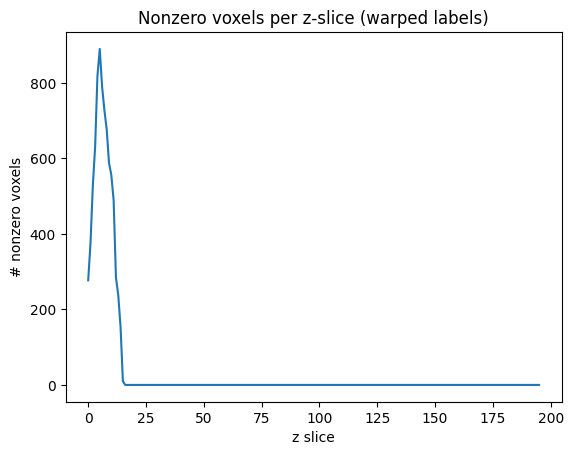

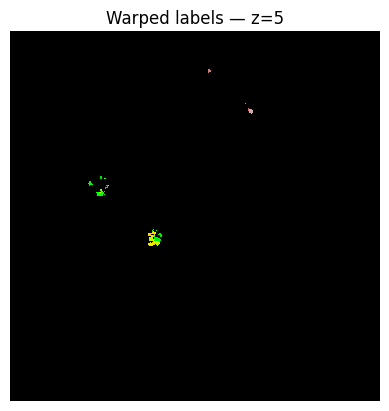

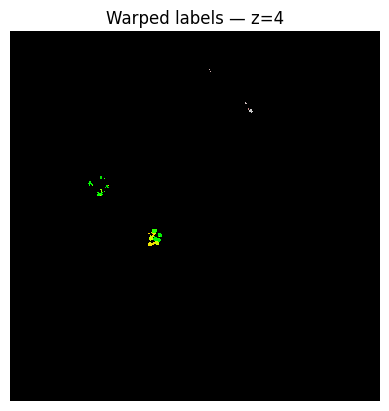

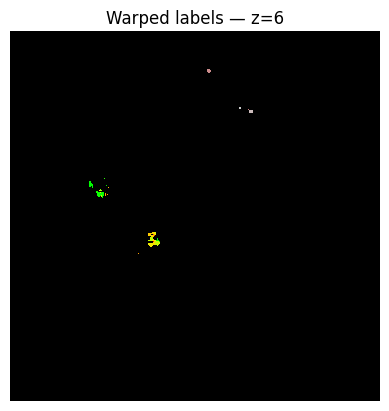

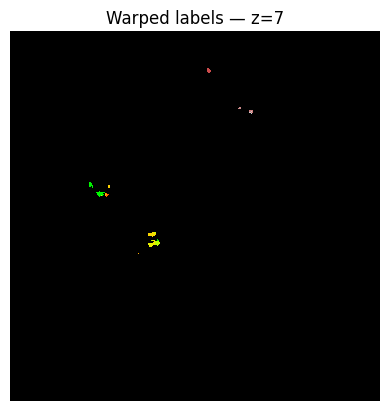

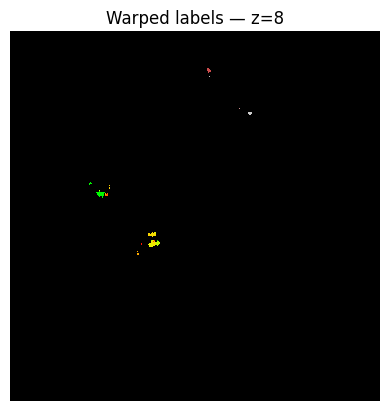

In [17]:

# # Make a Cellpose-compatible *_seg.npy from our warped labels
# from cellpose import utils

# warped_masks = conf_warped_in_2p.astype(np.int32)   # (Z,Y,X) labels, 0=bg, 1..N=cells
# out_base = "confocal_labels_in_2P_space"

# # Minimal dict that Cellpose GUI expects
# dat = {
#     "filename": out_base + ".tif",                 # just a hint; not required to exist
#     "masks": warped_masks,
#     "outlines": utils.outlines_list(warped_masks), # optional, but nice in GUI
#     "chan_choose": [0, 0],                         # metadata; ignored here
#     "ismanual": np.zeros(warped_masks.max() + 1, dtype=bool),
#     # 'flows' & 'colors' are optional; include placeholders to keep GUI happy
#     "flows": [None, None, None, None, None],
#     "colors": np.random.default_rng(0).random((warped_masks.max() + 1, 3)),
# }



# out_seg = out_base + "_seg.npy"
# np.save(out_seg, dat, allow_pickle=True)
# print("Wrote:", os.path.abspath(out_seg))

# # Alternative: save as a TIFF label volume (Cellpose GUI can read these too)
# import tifffile as tiff
# warped_masks = conf_warped_in_2p.astype(np.uint16)  # labels must be integers
# tiff.imwrite("confocal_labels_in_2P_space_labels.tif", warped_masks, photometric="minisblack")
# print("Saved confocal_labels_in_2P_space_labels.tif")

# Load your transformed label volume
warped_path = "confocal_labels_in_2P_space.npy"
conf_warped_in_2p = np.load(warped_path)

# --- print summaries ---
_summary(masks_conf, "BEFORE (confocal mask)")
_summary(conf_warped_in_2p, "AFTER  (warped conf→2P)") 

# --- build sample tables ---
df_before = _sample_table(masks_conf, n=1000, name="BEFORE")
df_after  = _sample_table(conf_warped_in_2p, n=1000, name="AFTER")

# --- display two scrollable tables ---
html_before = df_before.to_html(index=False)
html_after  = df_after.to_html(index=False)
styled = f"""
<div style="display:flex; gap:16px;">
  <div style="flex:1;">
    <h4 style="margin:4px 0;">BEFORE (confocal)</h4>
    {html_before.replace("<table", '<table style="display:block; max-height:400px; overflow-y:auto; width:100%;"')}
  </div>
  <div style="flex:1;">
    <h4 style="margin:4px 0;">AFTER (confocal → 2P)</h4>
    {html_after.replace("<table", '<table style="display:block; max-height:400px; overflow-y:auto; width:100%;"')}
  </div>
</div>
"""
display(HTML(styled))

# (optional) save for records
df_before.to_csv("warped_check_samples_before.csv", index=False)
df_after.to_csv("warped_check_samples_after.csv", index=False)
print("Saved warped_check_samples_before.csv and warped_check_samples_after.csv")

# assumes conf_warped_in_2p already in memory (or np.load as needed)
arr = conf_warped_in_2p
nz = (arr > 0)

total_vox = arr.size
total_nz  = int(nz.sum())
frac_nz   = total_nz / total_vox

print(f"Nonzero voxels: {total_nz} / {total_vox}  ({100*frac_nz:.4f}%)")
print("Value min/max:", int(arr.min()), int(arr.max()))

if arr.ndim == 3:
    nz_per_z = nz.reshape(arr.shape[0], -1).sum(axis=1)
    dfz = pd.DataFrame({"z": np.arange(arr.shape[0]), "nonzero_voxels": nz_per_z})
    display(dfz.head())
    plt.figure()
    plt.plot(dfz["z"], dfz["nonzero_voxels"])
    plt.xlabel("z slice")
    plt.ylabel("# nonzero voxels")
    plt.title("Nonzero voxels per z-slice (warped labels)")
    plt.show()

    # peek a few slices with most signal (if any)
    top_z = dfz.sort_values("nonzero_voxels", ascending=False).head(5)["z"].to_numpy()
    for z in top_z:
        if dfz.loc[dfz["z"] == z, "nonzero_voxels"].item() == 0:
            continue
        plt.figure()
        plt.imshow(arr[z], cmap="nipy_spectral", interpolation="nearest")
        plt.title(f"Warped labels — z={int(z)}")
        plt.axis("off")
        plt.show()

In [18]:
# ==== Re-warp with different inversion settings and compare ====
import numpy as np

try:
    import ants
except Exception as e:
    raise RuntimeError("ANTsPy is required here.") from e

def warp_with(transformlist, whichtoinvert=None, label_dtype=None):
    mov = _ants_from_mask(masks_conf, VOX_CONF, ants)           # confocal labels
    ref = _ants_from_mask(masks_2p,   VOX_2P,   ants)           # 2P grid as reference
    warped = ants.apply_transforms(
        fixed=ref, moving=mov,
        transformlist=transformlist,
        whichtoinvert=whichtoinvert,
        interpolator="nearestNeighbor",
    )
    out = warped.numpy()
    if label_dtype is not None:
        out = out.astype(label_dtype)
    return out

# 0) your original (no inversion)
w0 = warp_with(ANTs_TRANSFORMS, whichtoinvert=[False]*len(ANTs_TRANSFORMS), label_dtype=np.int32)
c0 = int((w0>0).sum())

# 1) invert all transforms
w1 = warp_with(ANTs_TRANSFORMS, whichtoinvert=[True]*len(ANTs_TRANSFORMS), label_dtype=np.int32)
c1 = int((w1>0).sum())

# 2) invert affine only (common fix)
invert_affine_only = [False]*len(ANTs_TRANSFORMS)
# assuming last is the affine; adjust if yours differs
invert_affine_only[-1] = True
w2 = warp_with(ANTs_TRANSFORMS, whichtoinvert=invert_affine_only, label_dtype=np.int32)
c2 = int((w2>0).sum())

print(f"Nonzero voxel counts:")
print(f"  original order (no invert): {c0}")
print(f"  invert ALL transforms:       {c1}")
print(f"  invert AFFINE only:          {c2}")

# Pick the best variant (most nonzero) for inspection
variants = [(c0, w0, "no_invert"), (c1, w1, "invert_all"), (c2, w2, "invert_affine")]
best = max(variants, key=lambda t: t[0])
best_count, best_arr, best_tag = best
print(f"Best variant: {best_tag} with {best_count} nonzero voxels")

# If the best has >0, adopt it as the warped result
if best_count > 0:
    conf_warped_in_2p = best_arr
    np.save(f"confocal_labels_in_2P_space_{best_tag}.npy", conf_warped_in_2p)
    print(f"Saved confocal_labels_in_2P_space_{best_tag}.npy")


ValueError: Cannot invert transform 0 (/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L427_f02/02_reg/01_r1-2p/transMatrices/L427_f02_round1_GCaMP_to_ref1Warp.nii.gz) because it is not a matrix

## 4) Load Cellpose masks and compute centroids

In [ ]:
is3d = (masks_conf.ndim == 3)
assert masks_2p.ndim == masks_conf.ndim, "Confocal and 2P masks must have same dimensionality (both 2D or both 3D)."

df_conf = compute_centroids(masks_conf)
df_2p   = compute_centroids(masks_2p)

print("Confocal centroids:", df_conf.shape, "| 2P centroids:", df_2p.shape)
df_conf.head(), df_2p.head()

# Print concise summaries
for m, n in [(masks_conf, "Confocal (HCR)"), (masks_2p, "2P (mCherry)")]:
    s = mask_summary(m, n)
    print(f"[{s['name']}] shape={s['shape']} ndim={s['ndim']} dtype={s['dtype']} "
          f"min={s['min']} max={s['max']} cells={s['n_cells']}")

# # Interactive viewer
# def _browse(which: str = "Confocal", z: int = 0):
#     arr = masks_conf if which == "Confocal" else masks_2p
#     img = safe_slice(arr, z)
#     plt.figure()
#     plt.imshow(img, cmap="nipy_spectral", interpolation="nearest")
#     if arr.ndim == 3:
#         plt.title(f"{which} — z={int(np.clip(z, 0, arr.shape[0]-1))}/{arr.shape[0]-1}")
#     else:
#         plt.title(f"{which} — 2D mask")
#     plt.axis("off")
#     plt.tight_layout()
#     plt.show()

# # Set slider range to cover the larger Z; safe_slice() clamps for the smaller stack.
# zmax = max(masks_conf.shape[0] if masks_conf.ndim == 3 else 1,
#            masks_2p.shape[0]   if masks_2p.ndim   == 3 else 1) - 1
# interact(
#     _browse,
#     which=Dropdown(options=["Confocal", "2P"], value="Confocal", description="Stack"),
#     z=IntSlider(min=0, max=max(0, zmax), step=1, value=0, description="z-plane")
# );

assert masks_conf.ndim == 3 and masks_2p.ndim == 3, "This viewer is for 3D stacks."

Zc, Zt = masks_conf.shape[0], masks_2p.shape[0]
zmax = max(Zc, Zt) - 1

def _browse_pair(z=0):
    # clamp independently so the slider always works even if Z counts differ
    zc = int(np.clip(z, 0, Zc-1))
    zt = int(np.clip(z, 0, Zt-1))
    imc = safe_slice(masks_conf, zc)
    imt = safe_slice(masks_2p,   zt)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
    axL, axR = axes

    im0 = axL.imshow(imc, cmap="nipy_spectral", interpolation="nearest")
    axL.set_title(f"Confocal (HCR)\nZ={zc}/{Zc-1}  shape={imc.shape}")
    axL.axis("off")

    im1 = axR.imshow(imt, cmap="nipy_spectral", interpolation="nearest")
    axR.set_title(f"2P (mCherry)\nZ={zt}/{Zt-1}  shape={imt.shape}")
    axR.axis("off")

    # keep identical display ranges so colors map comparably across z (optional)
    vmax = max(imc.max(), imt.max())
    im0.set_clim(0, vmax)
    im1.set_clim(0, vmax)

    plt.show()

interact(
    _browse_pair,
    z=IntSlider(min=0, max=zmax, step=1, value=min(Zc, Zt)//2, description="z-plane"),
);

Confocal centroids: (191, 4) | 2P centroids: (939, 4)
[Confocal (HCR)] shape=(155, 2048, 2048) ndim=3 dtype=uint16 min=0 max=191 cells=191
[2P (mCherry)] shape=(196, 750, 750) ndim=3 dtype=uint16 min=0 max=939 cells=939


interactive(children=(IntSlider(value=77, description='z-plane', max=195), Output()), _dom_classes=('widget-in…

## 3) Convert centroids to physical units (µm)

In [7]:

P_conf_um = idx_to_um(df_conf, VOX_CONF)
P_2p_um   = idx_to_um(df_2p,   VOX_2P)
print(f"P_conf_um shape: {P_conf_um.shape}, P_2p_um shape: {P_2p_um.shape}")



P_conf_um shape: (191, 3), P_2p_um shape: (939, 3)


## 4) Apply ANTs transform (confocal → 2P)

In [8]:

if HAVE_ANTSPY:
    print("Applying ANTs transform via ANTsPy...")
    P_conf_in_2p_um = apply_ants_transform_to_points(P_conf_um, is3d, ANTs_TRANSFORMS, VOX_CONF, VOX_2P)
else:
    print("ANTsPy not available. Exporting confocal centroids to CSV for antsApplyTransformsToPoints...")
    export_csv = "conf_centroids_input_points.csv"
    # antsApplyTransformsToPoints expects columns: x,y,(z) in index units of the MOVING image.
    moving_idx = um_to_idx_df(P_conf_um, VOX_CONF, is3d)
    moving_idx.to_csv(export_csv, index=False)
    print(f"Wrote {export_csv}.")
    print("""
Next steps (outside Python):
  antsApplyTransformsToPoints -d {2 if not is3d else 3}     -i conf_centroids_input_points.csv     -o conf_centroids_in_2p_index.csv     -t { ' -t '.join(ANTs_TRANSFORMS) }     --precision float
Then re-import here:
    fixed_idx = pd.read_csv("conf_centroids_in_2p_index.csv")
    P_conf_in_2p_um = idx_df_to_um(fixed_idx, VOX_2P, is3d)
""".strip())
    P_conf_in_2p_um = None


Applying ANTs transform via ANTsPy...


## 5) Match cells and compute distances

In [12]:
if P_conf_in_2p_um is None:
    raise RuntimeError("Transformed confocal centroids not available yet. Complete the ANTs step then re-run.")

labels_conf = df_conf["label"].to_numpy()
labels_2p   = df_2p["label"].to_numpy()

# --- matching ---
if MATCH_METHOD == "nn":
    dists, nn = nearest_neighbor_match(P_conf_in_2p_um, P_2p_um)
    matched_twoP_labels = labels_2p[nn]
    matched_conf_labels = labels_conf
elif MATCH_METHOD == "hungarian":
    dists, col_ind, row_ind = hungarian_match(P_conf_in_2p_um, P_2p_um, max_cost=np.inf)
    matched_conf_labels = labels_conf[row_ind]
    matched_twoP_labels = labels_2p[col_ind]
else:
    raise ValueError("MATCH_METHOD must be 'nn' or 'hungarian'")

# --- construct table ---
valid = dists <= MAX_DISTANCE_UM
matches = pd.DataFrame({
    "conf_label": matched_conf_labels,
    "twoP_label": matched_twoP_labels,
    "distance_um": dists,
    "within_gate": valid
}).sort_values("distance_um", ascending=True).reset_index(drop=True)

# --- display (scrollable HTML table) ---
# display(HTML(matches.to_html(index=False, max_rows=30, escape=False, notebook=True)))
# replace the display() line with this one-liner:
display(HTML(matches.to_html(index=False).replace(
    "<table", '<table style="display:block; max-height:600px; overflow-y:auto; width:100%;"')))

# --- summary stats ---
summary = summarize_distances(dists, valid)
print("Summary:", json.dumps(summary, indent=2))

# --- optional: save ---
matches.to_csv("centroid_matches_sorted.csv", index=False)
print("Saved centroid_matches_sorted.csv")

conf_label,twoP_label,distance_um,within_gate
114,469,198.041765,False
104,469,198.404930,False
115,469,203.958323,False
140,469,208.571075,False
146,469,209.262136,False
144,469,210.263144,False
152,469,210.323979,False
149,469,212.174824,False
145,469,212.338148,False
141,469,212.490499,False


Summary: {
  "N_total": 191,
  "N_within_gate": 0,
  "frac_within_gate": 0.0,
  "median_um": NaN,
  "p90_um": NaN
}
Saved centroid_matches_sorted.csv


## 6) Plots

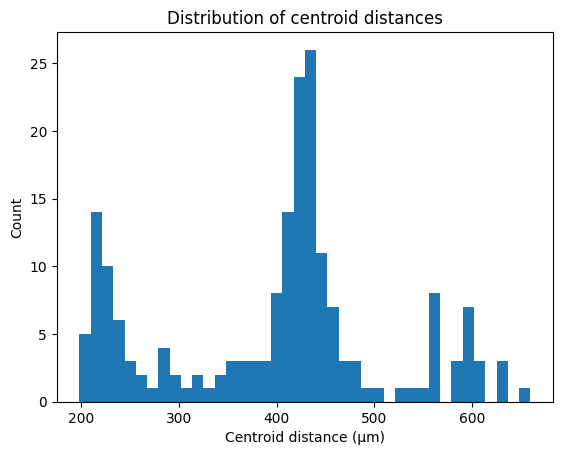

In [13]:

# Distance histogram
plt.figure()
plt.hist(matches["distance_um"].to_numpy(), bins=40)
plt.xlabel("Centroid distance (µm)")
plt.ylabel("Count")
plt.title("Distribution of centroid distances")
plt.show()


In [ ]:
try:
    from ipywidgets import interact, FloatSlider, FloatLogSlider, Checkbox
except Exception as e:
    print("ipywidgets not available:", e)
    raise

# convenience projections
Z2, Y2, X2 = P_2p_um[:,0], P_2p_um[:,1], P_2p_um[:,2]
Zc, Yc, Xc = P_conf_in_2p_um[:,0], P_conf_in_2p_um[:,1], P_conf_in_2p_um[:,2]

zmin = float(min(Z2.min(), Zc.min()))
zmax = float(max(Z2.max(), Zc.max()))
default_thick = 4.0  # µm half-thickness on each side of the slider plane

def _plot_slice(z_um=0.0, thickness_um=default_thick, show_conf=True, show_2p=True, show_matches=False):
    plt.figure()
    # 2P points in the slab
    if show_2p:
        m2 = np.abs(Z2 - z_um) <= thickness_um
        plt.scatter(X2[m2], Y2[m2], s=8, label="2P", alpha=0.9)
    # confocal→2P points in the slab
    if show_conf:
        mc = np.abs(Zc - z_um) <= thickness_um
        plt.scatter(Xc[mc], Yc[mc], s=8, alpha=0.6, label="Conf→2P")
    # optional: draw match lines for pairs whose both endpoints fall in the slab
    if show_matches and 'matches' in globals():
        # build quick label→coord maps
        coord_2p = dict(zip(df_2p["label"].to_numpy(), P_2p_um))
        coord_conf = dict(zip(df_conf["label"].to_numpy(), P_conf_in_2p_um))
        for _, row in matches.iterrows():
            a = coord_conf.get(int(row["conf_label"]))
            b = coord_2p.get(int(row["twoP_label"]))
            if a is None or b is None:
                continue
            if (abs(a[0]-z_um) <= thickness_um) and (abs(b[0]-z_um) <= thickness_um):
                plt.plot([a[2], b[2]], [a[1], b[1]], linewidth=0.5)

    plt.gca().invert_yaxis()
    plt.xlabel("x (µm)")
    plt.ylabel("y (µm)")
    plt.title(f"Centroids near z = {z_um:.2f} µm (±{thickness_um:.2f})")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

interact(
    _plot_slice,
    z_um=FloatSlider(min=zmin, max=zmax, step=0.5, value=(zmin+zmax)/2, description="z (µm)"),
    thickness_um=FloatSlider(min=0.5, max=20.0, step=0.5, value=default_thick, description="slab ±µm"),
    show_conf=Checkbox(value=True, description="show Conf→2P"),
    show_2p=Checkbox(value=True, description="show 2P"),
    show_matches=Checkbox(value=False, description="show match lines"),
);

## 7) Save results

In [ ]:

out_matches_csv = "centroid_matches.csv"
matches.to_csv(out_matches_csv, index=False)
print(f"Wrote {out_matches_csv}")

out_summary_json = "qc_summary.json"
with open(out_summary_json, "w") as f:
    json.dump(summary, f, indent=2)
print(f"Wrote {out_summary_json}")



## Notes & Tips

- **Transform direction**: These steps assume your ANTs transform maps *confocal → 2P*. If your files represent the reverse direction, invert them or swap roles.
- **Gate selection**: Start with ~1 soma diameter (e.g., 8–12 µm for juvenile zebrafish thalamus). Report fraction within gate, median, p90.
- **Outliers**: Investigate > gate by cropping around predicted pairs; often due to segmentation misses or local warp strain.
- **Warp health**: Consider computing a log-Jacobian image from the SyN warp and correlating distance outliers with high-deformation regions.
- **Reproducibility**: Keep a copy of your exact `VOX_*`, transform filenames, and Cellpose versions alongside the outputs.
